In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from src.config import Config
from src.dataset import get_dataloader
from src.utils import MultimodalModel, train, validate

In [3]:
config = Config()

# Этап 1. Исследовательский анализ (EDA)


In [3]:
df_dish = pd.read_csv('data/dish.csv')
print(df_dish.shape)
display(df_dish.head())

df_ingred = pd.read_csv('data/ingredients.csv')
print(df_ingred.shape)
display(df_ingred.head())

(3262, 5)


,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


(555, 2)


,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


In [4]:
ingredients_map = dict(zip(df_ingred['id'], df_ingred['ingr']))

ingredients_str = df_dish['ingredients'].tolist()

text_list = []
for row in ingredients_str:
    ingr_ids = []
    for part in row.split(';'):
        part = part.strip()
        if part.startswith('ingr_'):
            num_str = part[5:]
            if num_str.isdigit():
                ingr_ids.append(int(num_str))
    
    ingr_names = [ingredients_map.get(i, "unknown") for i in ingr_ids]
    text = " ".join(ingr_names)
    text_list.append(text)

df_dish['ingredients_list'] = text_list

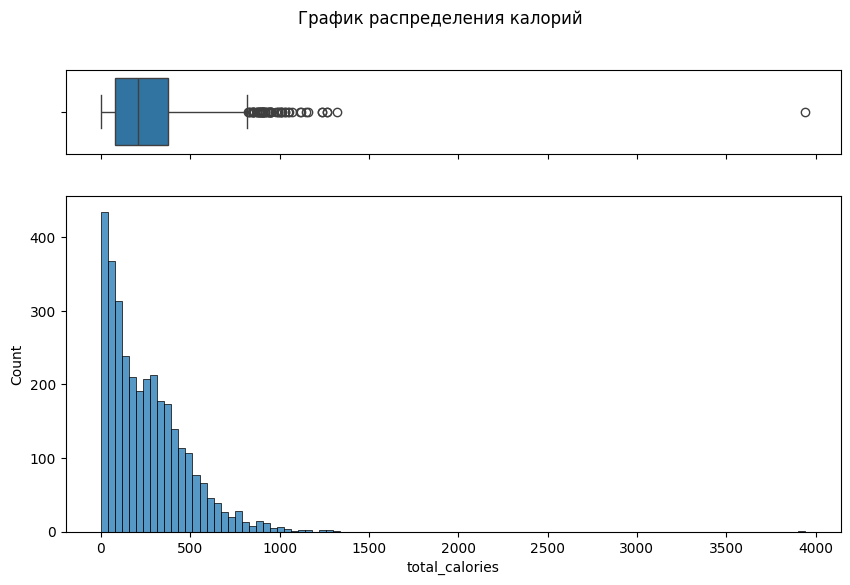

In [5]:
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=(0.20, 0.80))

sns.boxplot(data=df_dish, x='total_calories', ax=ax_box)
sns.histplot(data=df_dish, x='total_calories', ax=ax_hist)

fig.suptitle('График распределения калорий')
plt.show()

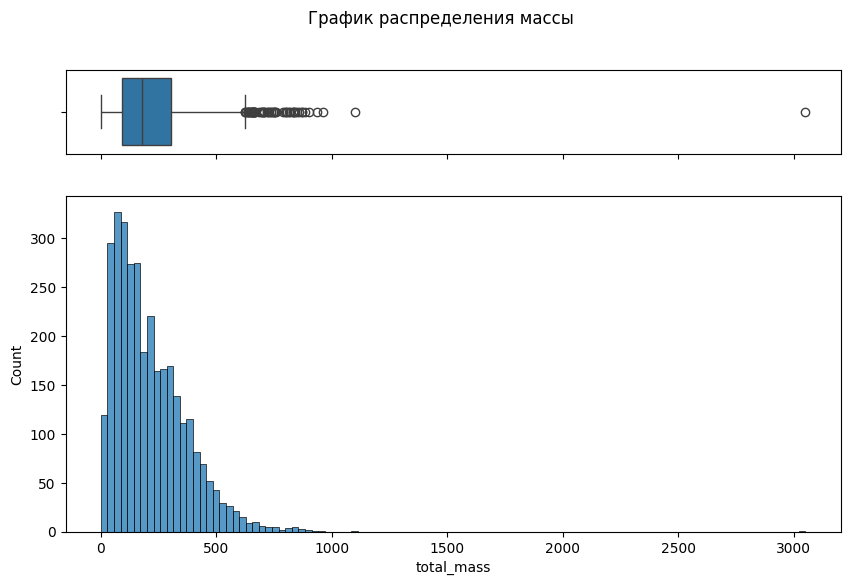

In [6]:
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=(0.20, 0.80))

sns.boxplot(data=df_dish, x='total_mass', ax=ax_box)
sns.histplot(data=df_dish, x='total_mass', ax=ax_hist)

fig.suptitle('График распределения массы')
plt.show()

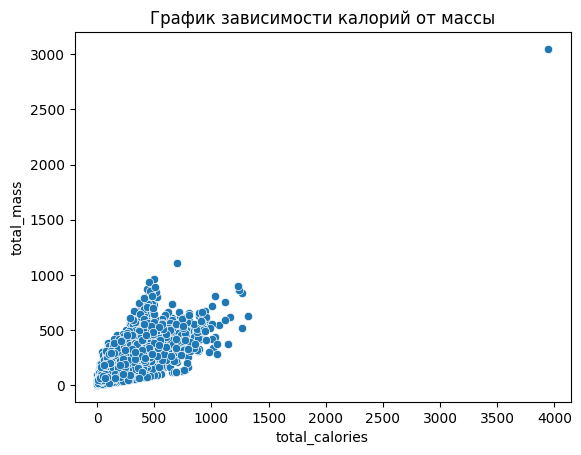

In [7]:
sns.scatterplot(x=df_dish['total_calories'], y=df_dish['total_mass'])
plt.title('График зависимости калорий от массы')
plt.show()

spinach (raw) tortilla chips corn cheese white rice cherry tomatoes lime tomatoes chili garlic salt sour cream onions black beans


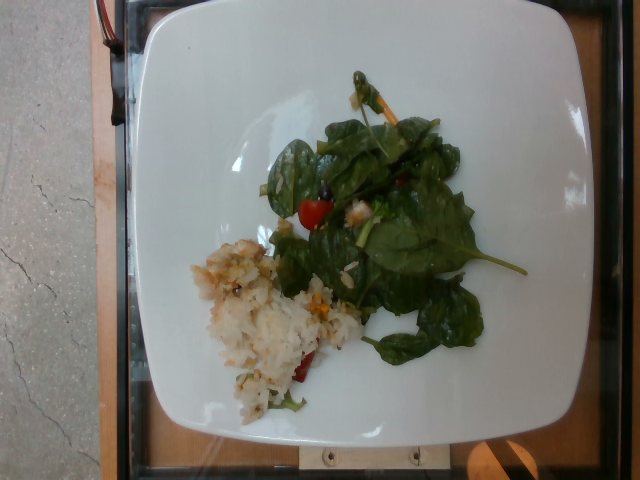

In [ ]:
# выводим шумовые данные
noise = df_dish.iloc[df_dish['total_calories'].idxmax()]
print(noise['ingredients_list'])

img_path = os.path.join(config.IMAGE_DIR, noise['dish_id'], "rgb.png")
image = Image.open(img_path).convert("RGB")
image

In [ ]:
# удаляем выброc: удаляем папку с картинкой и запись в датасете
removed_ids = set(df_dish[df_dish.total_calories > 2000]['dish_id'])

for dish_id in removed_ids:
    folder_path = os.path.join(config.IMAGE_DIR, str(dish_id))
    
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print('Папка удалена')

df_dish_prepare = df_dish[df_dish.total_calories < 2000]

Папка удалена


In [ ]:
# разбиваем выборку на train, val, test
train = df_dish_prepare[df_dish_prepare.split == 'train']
val = df_dish_prepare[df_dish_prepare.split == 'test']

train, test = train_test_split(train, random_state=config.SEED, test_size=0.1)

test.loc[:, 'split'] = 'test'
val.loc[:, 'split'] = 'val'

df = pd.concat([train, val, test]).reset_index(drop=True)

split
train    2478
val       507
test      276
Name: count, dtype: int64


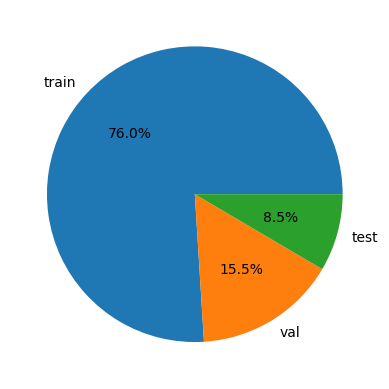

In [13]:
split = df.split.value_counts()
print(split)

plt.pie(split, autopct='%1.1f%%', labels=split.index)
plt.show()

In [ ]:
df.to_csv('data/dish_cleaned.csv')

**Вывод:**

EDA:
- Распределение total_calories скошено вправо: большинство блюд лежит в низком диапазоне, есть хвост больших значений.
- Выброс удалён, так как будет портится обучение и MAE.
- Калории растут вместе с массой.

Задача регрессии: предсказываем total_calories.

В качестве аугментации используем:
- RandomResizedCropAndInterpolation
- RandomHorizontalFlip
- ColorJitter

Используем мультимодальную модель:
- для текста (ingredients) берем bert-base-uncased.
- для изображений берем efficientnet_b3 (timm).
- регрессионная “голова”.

Цель: достичь метрики MAE < 50 на тестовой выборке.

# Этап 2. Пайплайн обучения

In [18]:
train_loader, val_loader, test_loader = get_dataloader(config)

In [20]:
batch = next(iter(train_loader))

print('Ключи:', list(batch.keys()))
for k, v in batch.items():
    if torch.is_tensor(v):
        print(f"{k}: {v.shape}")
    else:
        print(f"{k}: {type(v)}")

print(f"calory: {batch['calory'][:3].tolist()}")

Ключи: ['input_ids', 'attention_mask', 'calory', 'mass', 'dish_id', 'image']
input_ids: torch.Size([16, 128])
attention_mask: torch.Size([16, 128])
calory: torch.Size([16])
mass: torch.Size([16])
dish_id: <class 'list'>
image: torch.Size([16, 3, 288, 288])
calory: [363.658203125, 298.0343933105469, 128.09861755371094]


# Этап 3. Обучение модели

In [ ]:
model, train_losses, val_maes, best_mae = train(config)

Using device: cuda


Epoch 1/30 | avg_Loss: 225.0549 | Train MAE: 234.59 | Val MAE: 224.5623
Новая лучшая модель! MAE = 224.56
Чекпоинт сохранён



Epoch 2/30 | avg_Loss: 197.9707 | Train MAE: 207.63 | Val MAE: 199.3687
Новая лучшая модель! MAE = 199.37
Чекпоинт сохранён



Epoch 3/30 | avg_Loss: 174.8411 | Train MAE: 184.46 | Val MAE: 176.1144
Новая лучшая модель! MAE = 176.11
Чекпоинт сохранён



Epoch 4/30 | avg_Loss: 145.5867 | Train MAE: 154.92 | Val MAE: 143.6145
Новая лучшая модель! MAE = 143.61
Чекпоинт сохранён



Epoch 5/30 | avg_Loss: 120.1407 | Train MAE: 129.27 | Val MAE: 117.9635
Новая лучшая модель! MAE = 117.96
Чекпоинт сохранён



Epoch 6/30 | avg_Loss: 100.4285 | Train MAE: 109.46 | Val MAE: 99.2292
Новая лучшая модель! MAE = 99.23
Чекпоинт сохранён



Epoch 7/30 | avg_Loss: 87.6370 | Train MAE: 96.71 | Val MAE: 87.4365
Новая лучшая модель! MAE = 87.44
Чекпоинт сохранён



Epoch 8/30 | avg_Loss: 78.2551 | Train MAE: 87.22 | Val MAE: 81.0118
Новая лучшая модель! MAE = 81.01
Чекпоинт сохранён



Epoch 9/30 | avg_Loss: 73.5635 | Train MAE: 82.50 | Val MAE: 78.2979
Новая лучшая модель! MAE = 78.30
Чекпоинт сохранён



Epoch 10/30 | avg_Loss: 69.5063 | Train MAE: 78.43 | Val MAE: 78.7151
Чекпоинт сохранён



Epoch 11/30 | avg_Loss: 64.8951 | Train MAE: 73.73 | Val MAE: 76.1255
Новая лучшая модель! MAE = 76.13
Чекпоинт сохранён



Epoch 12/30 | avg_Loss: 62.5744 | Train MAE: 71.33 | Val MAE: 73.0260
Новая лучшая модель! MAE = 73.03
Чекпоинт сохранён



Epoch 13/30 | avg_Loss: 60.0446 | Train MAE: 68.87 | Val MAE: 72.1877
Новая лучшая модель! MAE = 72.19
Чекпоинт сохранён



Epoch 14/30 | avg_Loss: 57.2534 | Train MAE: 66.02 | Val MAE: 71.0321
Новая лучшая модель! MAE = 71.03
Чекпоинт сохранён



Epoch 15/30 | avg_Loss: 55.5900 | Train MAE: 64.34 | Val MAE: 67.6969
Новая лучшая модель! MAE = 67.70
Чекпоинт сохранён



Epoch 16/30 | avg_Loss: 54.2477 | Train MAE: 62.99 | Val MAE: 73.5670
Чекпоинт сохранён



Epoch 17/30 | avg_Loss: 52.5417 | Train MAE: 61.25 | Val MAE: 69.4598
Чекпоинт сохранён



Epoch 18/30 | avg_Loss: 51.8197 | Train MAE: 60.51 | Val MAE: 68.5109
Чекпоинт сохранён



Epoch 19/30 | avg_Loss: 49.6124 | Train MAE: 58.25 | Val MAE: 66.3916
Новая лучшая модель! MAE = 66.39
Чекпоинт сохранён



Epoch 20/30 | avg_Loss: 48.9527 | Train MAE: 57.52 | Val MAE: 65.4620
Новая лучшая модель! MAE = 65.46
Чекпоинт сохранён



Epoch 21/30 | avg_Loss: 48.0496 | Train MAE: 56.70 | Val MAE: 64.2494
Новая лучшая модель! MAE = 64.25
Чекпоинт сохранён



Epoch 22/30 | avg_Loss: 47.0328 | Train MAE: 55.64 | Val MAE: 64.8668
Чекпоинт сохранён



Epoch 23/30 | avg_Loss: 45.6823 | Train MAE: 54.25 | Val MAE: 64.0988
Новая лучшая модель! MAE = 64.10
Чекпоинт сохранён



Epoch 24/30 | avg_Loss: 44.5220 | Train MAE: 53.16 | Val MAE: 63.5571
Новая лучшая модель! MAE = 63.56
Чекпоинт сохранён



Epoch 25/30 | avg_Loss: 44.6200 | Train MAE: 53.24 | Val MAE: 64.6507
Чекпоинт сохранён



Epoch 26/30 | avg_Loss: 42.2430 | Train MAE: 50.71 | Val MAE: 63.9948
Чекпоинт сохранён



Epoch 27/30 | avg_Loss: 43.2050 | Train MAE: 51.71 | Val MAE: 65.4699
Чекпоинт сохранён



Epoch 28/30 | avg_Loss: 41.8551 | Train MAE: 50.46 | Val MAE: 63.5528
Новая лучшая модель! MAE = 63.55
Чекпоинт сохранён



Epoch 29/30 | avg_Loss: 40.6890 | Train MAE: 49.24 | Val MAE: 66.7081
Чекпоинт сохранён



Epoch 30/30 | avg_Loss: 39.8148 | Train MAE: 48.29 | Val MAE: 63.0727
Новая лучшая модель! MAE = 63.07
Чекпоинт сохранён

Обучение завершено. Лучший Val MAE: 63.07


# Этап 4. Валидация качества

In [5]:
model = MultimodalModel(config)
model.load_state_dict(torch.load(config.SAVE_PATH, map_location=config.DEVICE, weights_only=True))
model.to(config.DEVICE)
model.eval()

_, _, test_loader = get_dataloader(config, batch_size=1)

predictions = []
true = []
dish_ids = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(config.DEVICE)
        attention_mask = batch['attention_mask'].to(config.DEVICE)
        image = batch['image'].to(config.DEVICE)
        dish_id = batch['dish_id'][0]
        y = batch['calory'].to(config.DEVICE)

        pred = model(input_ids, attention_mask, image)
        
        predictions.append(pred.cpu().item())
        true.append(y.cpu().item())
        dish_ids.append(dish_id)

# вычисляем MAE
mae = np.mean(np.abs(np.array(predictions) - np.array(true)))
print(f"MAE на тестовой выборке: {mae:.2f}")

MAE на тестовой выборке: 50.20


In [ ]:
# создаем датафрейм для вывода ТОП-5
test_results = pd.DataFrame({
    'dish_id': dish_ids,
    'true_calories': true,
    'predicted_calories': predictions,
    'error': np.abs(np.array(predictions) - np.array(true))
})

test_results = test_results.sort_values(by='error', ascending=False).reset_index(drop=True)

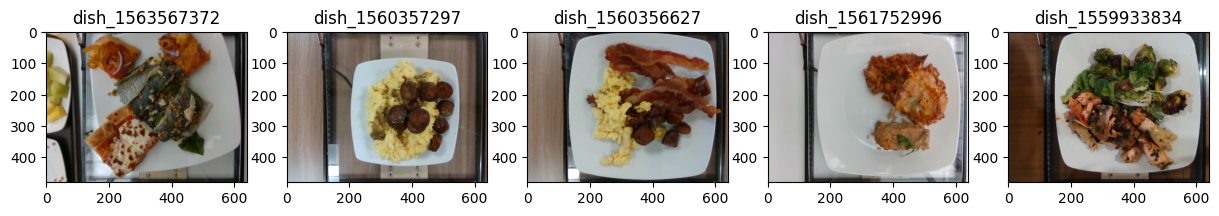

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

for ind in range(5):
    img_path = os.path.join(config.IMAGE_DIR, test_results['dish_id'].iloc[ind], "rgb.png")
    image = Image.open(img_path).convert("RGB")
    ax[ind].imshow(image)
    ax[ind].set(title=f"{test_results['dish_id'].iloc[ind]}")

In [20]:
bad_dish = test_results['dish_id'].iloc[:5].tolist()

df = pd.read_csv(config.DISH_CSV)
df[df.dish_id.isin(bad_dish)]

,Unnamed: 0,dish_id,total_calories,total_mass,ingredients,split,ingredients_list
3065,3065,dish_1560357297,942.454041,492.0,ingr_0000000039;ingr_0000000008,test,sausage scrambled eggs
3103,3103,dish_1559933834,775.029236,458.0,ingr_0000000312;ingr_0000000332;ingr_000000021...,test,pepper salmon pears parsley lemon juice lentil...
3157,3157,dish_1560356627,980.047974,301.0,ingr_0000000008;ingr_0000000004;ingr_0000000039,test,scrambled eggs bacon sausage
3170,3170,dish_1563567372,951.910889,590.0,ingr_0000000471;ingr_0000000049;ingr_000000029...,test,cherry tomatoes fish salt wheat berry lemon ju...
3179,3179,dish_1561752996,848.655762,415.0,ingr_0000000122;ingr_0000000515;ingr_000000002...,test,garlic arugula brown rice thyme salt cilantro ...


**Вывод**

Визуализированы ТОП-5 плохих примеров.
Плохие результаты могут быть:
- из-за плохого отображения ингридиентов (не совсем понятно, что на картинке).
- несоответствие между текстом и изображением.
- мало примеров с высокой калорийностью. Модель хуже распознает такие блюда.